In [1]:
!python --version

Python 3.10.13


In [2]:
!pip install tensorflow==2.15.0 scipy==1.11.4 imbalanced-learn scikit-plot ipykernel numpy pandas scikit-learn seaborn matplotlib opencv-python opencv-python-headless wurlitzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import scikitplot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Set TensorFlow logging level to ERROR
tf.get_logger().setLevel("ERROR")

In [5]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

# Check if GPU is used by TensorFlow
print("GPU in use: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  2
TensorFlow Version:  2.15.0
GPU in use:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Read data

In [6]:
df = pd.read_csv('/kaggle/input/vinmammo-75-fullsize/full_df.csv')
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,9bab34fb6637f3921df32b4a215385ed,e3531910704e16940109920a082a44c0,cae99f03d6140de07f07aefb4cd56894,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
1,c56cc50b66e5dec5669109775a6e86b1,fc2a541686a034dcee5210351421281f,b006f3d0f9d31b9f5b2bff0590bc9329,L,CC,2812,2012,BI-RADS 1,DENSITY A,training
2,68b4c3418c32a4ceded51336795166d8,f7fb64af935152315c2712e0073cf8cd,296b49445da9a1c1cd74309803fb1231,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
3,968fd0c76a33137d8c227041ea728bf6,f3de135bea9911aa421a4b51bab4c0d1,c89a8dd3fc80a4927de00ada5668293f,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
4,c488d7ef379be78343fd91eefa9cc477,f70111ca12d8c3650bdb048138e3d3c5,bac4fa932577504e96b0502fcfd600e5,L,CC,2812,2012,BI-RADS 1,DENSITY A,training
...,...,...,...,...,...,...,...,...,...,...
15999,5e9175554fa9d6b9fb424d7065be4f20,a07d1cc99c7611c815ea99acb324f3b6,4adfc32f03228403f518f24e9b9313cf,R,MLO,3518,2800,BI-RADS 1,DENSITY C,test
16000,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,4835a79d7e25eebd20104e7147cbcfb4,L,CC,3518,2800,BI-RADS 2,DENSITY C,test
16001,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,ebb437593a3fc80277296638f0607f5b,L,MLO,3518,2800,BI-RADS 2,DENSITY C,test
16002,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,9188a01b6b648cee39fb70702a860141,R,CC,3518,2800,BI-RADS 1,DENSITY C,test


In [7]:
df['image_path'] = '/kaggle/input/vinmammo-75-fullsize/png/png/' + df['study_id'] + '/' + df['image_id'] + '.png'
df['label'] = df['breast_birads'].map({'BI-RADS 1': '0',
                                       'BI-RADS 2': '0',
                                       'BI-RADS 3': '1',
                                       'BI-RADS 4': '1',
                                       'BI-RADS 5': '1'})

In [8]:
train_df = df[df['split'] == 'training']

tmp_test_df = df[df['split'] == 'test']
test_df, val_df = train_test_split(tmp_test_df, test_size=0.5, stratify=tmp_test_df['label'], random_state=42)

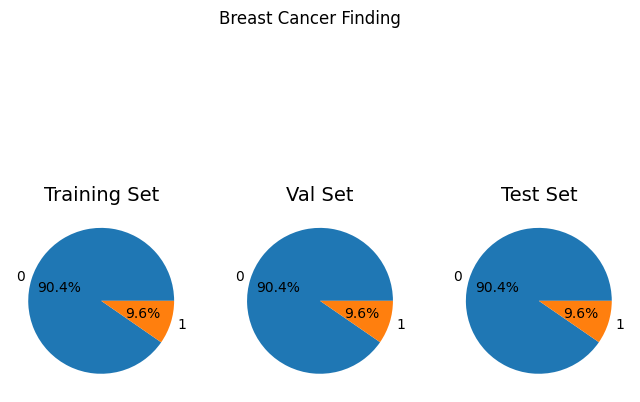

In [9]:
# label distributions
import matplotlib.pyplot as plt
value = train_df['label'].value_counts()
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
fig.suptitle('Breast Cancer Finding')
axs[0].pie(value, labels=value.index, autopct='%1.1f%%')
axs[0].set_title('Training Set', fontsize=14)

# label distributions
value_1 = val_df['label'].value_counts()
axs[1].pie(value_1, labels=value_1.index, autopct='%1.1f%%')
axs[1].set_title('Val Set', fontsize=14)

# label distributions
value_2 = test_df['label'].value_counts()
axs[2].pie(value_2, labels=value_2.index, autopct='%1.1f%%')
axs[2].set_title('Test Set', fontsize=14)

plt.show()

In [10]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors.
    '''

    color = 'rgb'
    img_size = (224, 224)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    tr_gen = ImageDataGenerator(horizontal_flip= True)
    ts_gen = ImageDataGenerator()
    
    # Extract features and labels from the training dataframe
    X_train = train_df[['image_path']].values  # Assuming 'image_path' is the column with image paths
    y_train = train_df['label'].values

    # Apply random undersampling using RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Combine resampled features and labels into a new DataFrame
    train_resampled_df = pd.DataFrame({'image_path': X_resampled.flatten(), 'label': y_resampled})

    # Create ImageDataGenerator for the resampled training data
    train_gen = tr_gen.flow_from_dataframe(train_resampled_df, x_col='image_path', y_col='label', target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

#     train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col= 'label', target_size=img_size, class_mode= 'categorical',
#                                            color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'image_path', y_col= 'label', target_size=img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= False, batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'image_path', y_col= 'label', target_size=img_size, class_mode= 'categorical',
                                          color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

## Visualize Dataset

In [11]:
batch_size = 16
train_gen, valid_gen, test_gen = create_gens(train_df, val_df, test_df, batch_size)

Found 2312 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


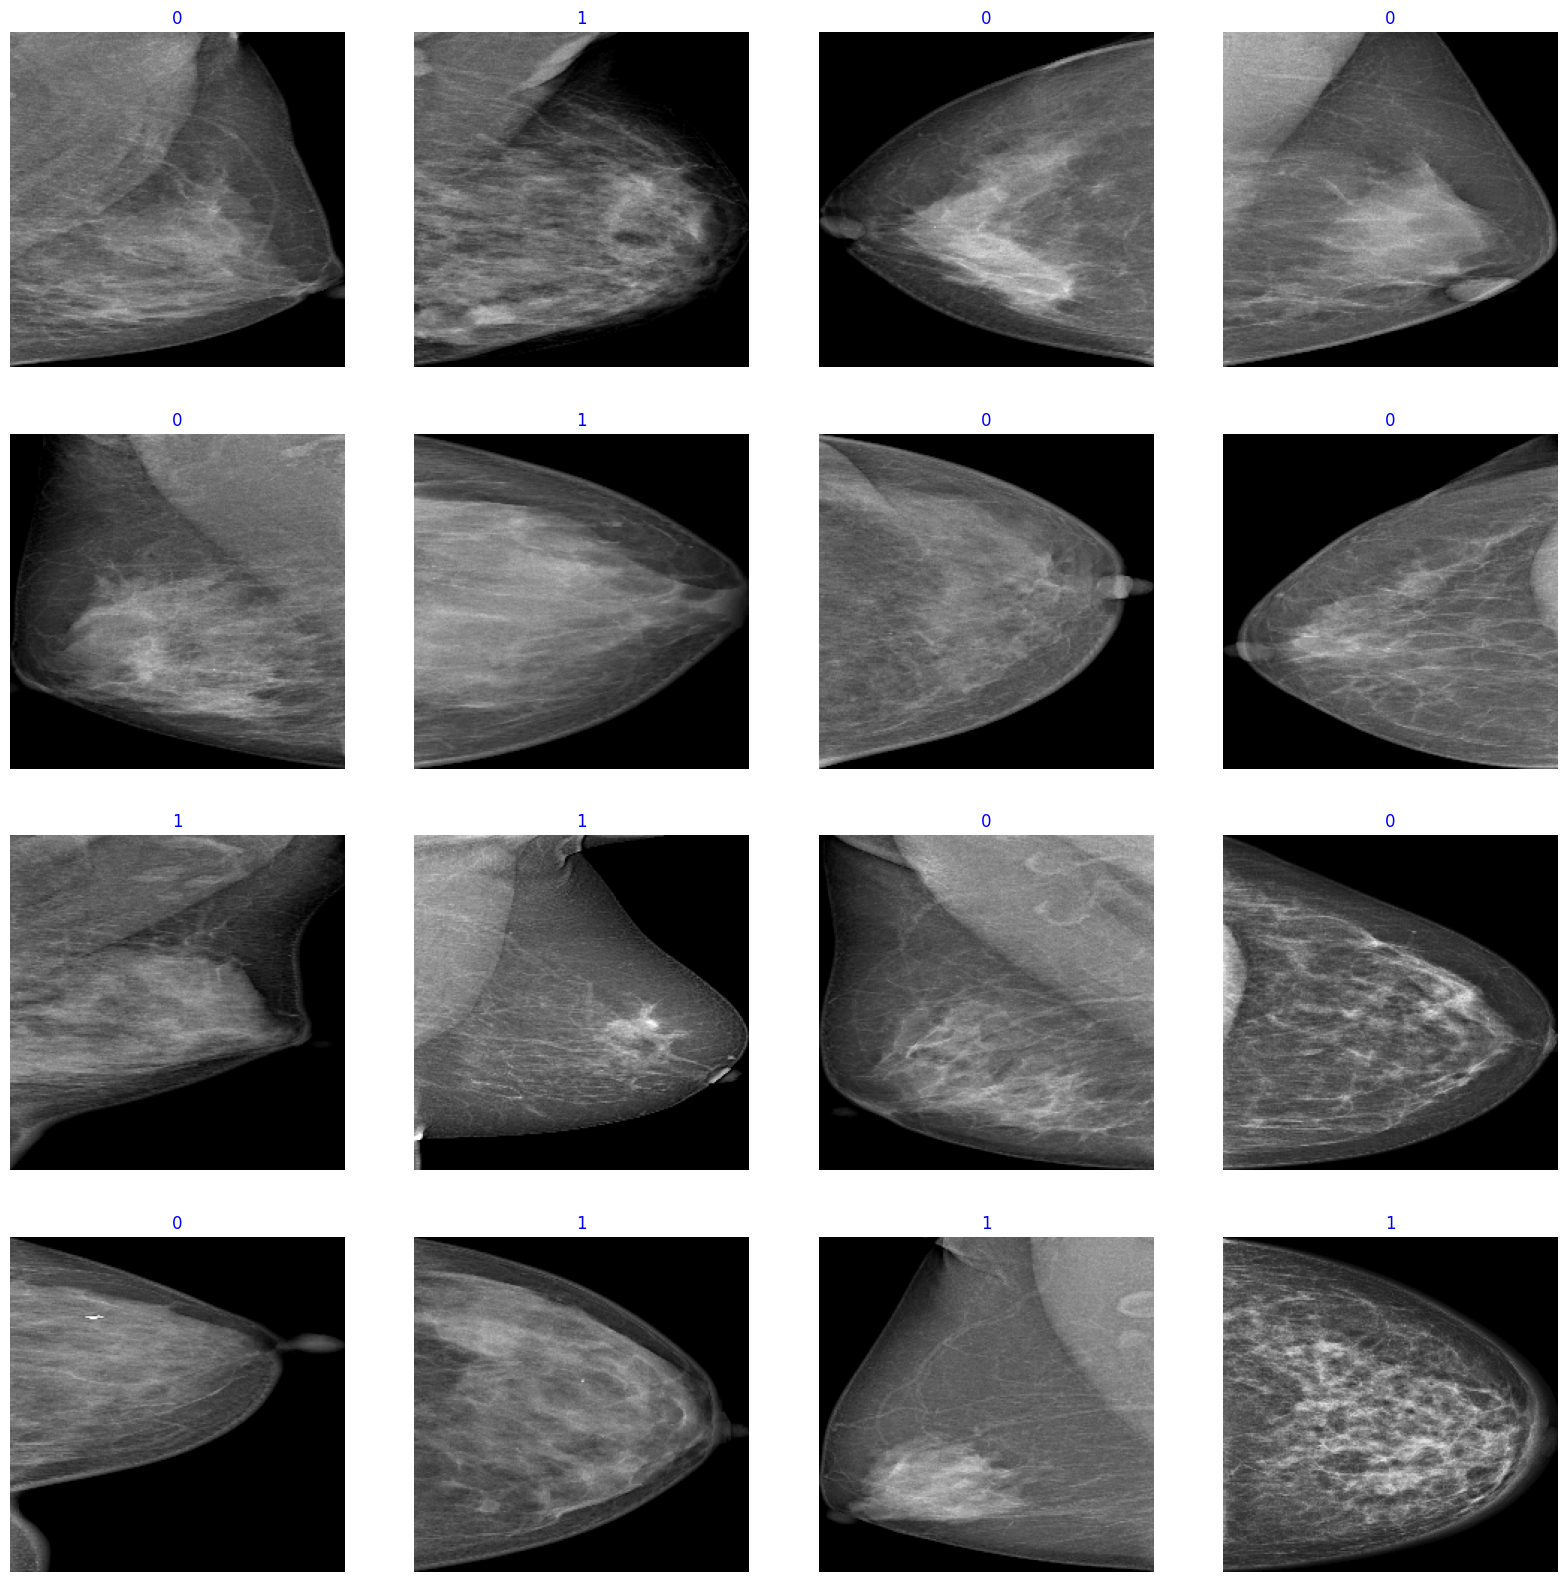

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

## Model 

In [13]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                               weights="imagenet",
                                                               input_shape=img_shape, pooling='max')


model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_regularizer=regularizers.l2(0.02),
               activity_regularizer=regularizers.l1(0.008),
               bias_regularizer=regularizers.l1(0.008), activation='relu'),
    Dropout(rate=0.55),
#     Dense(251, kernel_regularizer=regularizers.l2(0.016),
#                activity_regularizer=regularizers.l1(0.006),
#                bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dense(class_count, activation= 'softmax')])

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.AUC(curve='ROC', name='auc'),
                        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
                        'accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                         

In [14]:
import os
output_dir = '/kaggle/working/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

checkpoint_filepath = output_dir + '/best_model.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='min',
                                   verbose=1)

In [16]:
epochs = 50
history = model.fit(train_gen, epochs=epochs, verbose=1,
                    validation_data= valid_gen,
                    validation_steps=None, shuffle=False,
#                     class_weight=dict(enumerate(class_weights)),
                    callbacks=[early_stopping, model_checkpoint]
                    )

Epoch 1/50


2024-03-09 17:05:52.865865: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1710003959.862033     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 [==============================] - ETA: 0s - loss: 12.6440 - recall: 0.5251 - precision: 0.5251 - auc: 0.5327 - pr_auc: 0.5230 - accuracy: 0.5251
Epoch 1: val_loss improved from inf to 9.10566, saving model to /kaggle/working/output/best_model.h5
145/145 [==============================] - 198s 1s/step - loss: 12.6440 - recall: 0.5251 - precision: 0.5251 - auc: 0.5327 - pr_auc: 0.5230 - accuracy: 0.5251 - val_loss: 9.1057 - val_recall: 0.5680 - val_precision: 0.5680 - val_auc: 0.6137 - val_pr_auc: 0.6213 - val_accuracy: 0.5680
Epoch 2/50
145/145 [==============================] - ETA: 0s - loss: 7.8355 - recall: 0.5536 - precision: 0.5536 - auc: 0.5727 - pr_auc: 0.5599 - accuracy: 0.5536
Epoch 2: val_loss improved from 9.10566 to 6.27584, saving model to /kaggle/working/output/best_model.h5
145/145 [==============================] - 112s 771ms/step - loss: 7.8355 - recall: 0.5536 - precision: 0.5536 - auc: 0.5727 - pr_auc: 0.5599 - accuracy: 0.5536 - val_loss: 6.2758 - val_recal

In [17]:
# history.history

In [18]:
model.save_weights(f'{output_dir}/model_weights.h5')
val_df.to_csv(f'{output_dir}/val_df.csv')
test_df.to_csv(f'{output_dir}/test_df.csv')

## Visualize model training process

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']

precision = history.history['precision']
val_precision = history.history['val_precision']

# f1 = history.history['f1_score']
# val_f1 = history.history['val_f1_score']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(recall))

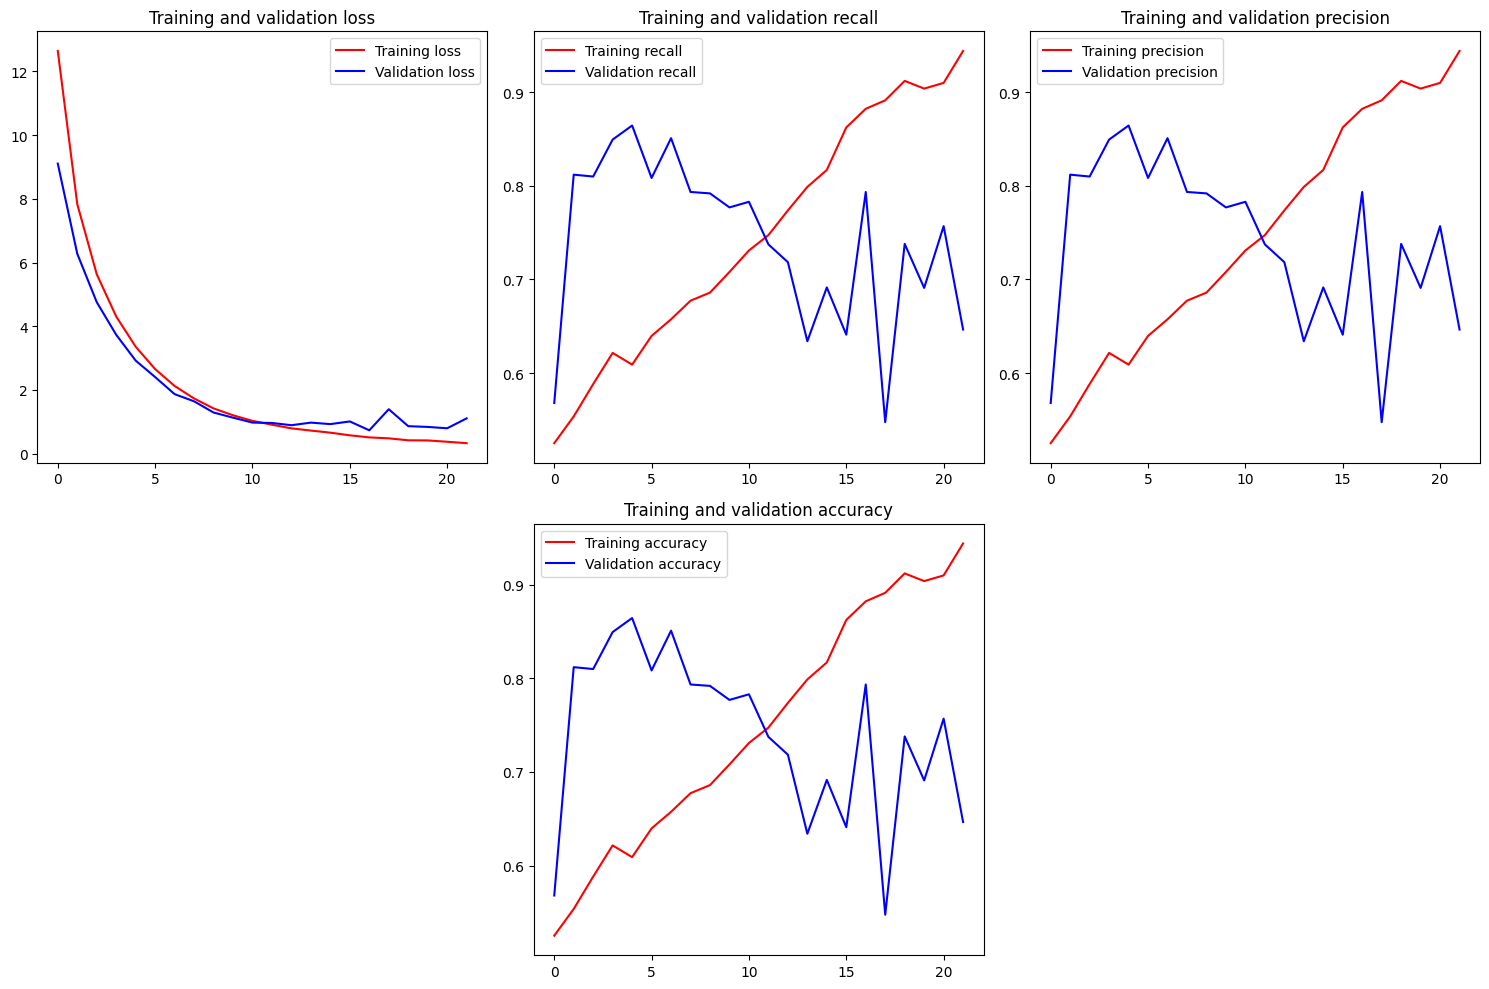

In [20]:
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting 
axs[0, 0].plot(epochs, loss, 'r', label='Training loss')
axs[0, 0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0, 0].set_title('Training and validation loss')
axs[0, 0].legend(loc=0)

axs[0, 1].plot(epochs, recall, 'r', label='Training recall')
axs[0, 1].plot(epochs, val_recall, 'b', label='Validation recall')
axs[0, 1].set_title('Training and validation recall')
axs[0, 1].legend(loc=0)

axs[0, 2].plot(epochs, precision, 'r', label='Training precision')
axs[0, 2].plot(epochs, val_precision, 'b', label='Validation precision')
axs[0, 2].set_title('Training and validation precision')
axs[0, 2].legend(loc=0)
# Hide the empty subplot
# axs[0, 2].axis('off')

# axs[1, 0].plot(epochs, f1, 'r', label='Training f1_score')
# axs[1, 0].plot(epochs, val_f1, 'b', label='Validation f1_score')
# axs[1, 0].set_title('Training and validation f1_score')
# axs[1, 0].legend(loc=0)
axs[1, 0].axis('off')

axs[1, 1].plot(epochs, accuracy, 'r', label='Training accuracy')
axs[1, 1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
axs[1, 1].set_title('Training and validation accuracy')
axs[1, 1].legend(loc=0)
# axs[1, 1].axis('off')


# Hide the empty subplot
axs[1, 2].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Evaluate model

In [21]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

25/25 [==============================] - 71s 3s/step - loss: 1.1117 - recall: 0.6720 - precision: 0.6720 - auc: 0.7063 - pr_auc: 0.6685 - accuracy: 0.6720


## Get Predictions

In [22]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
print(y_pred)

25/25 [==============================] - 54s 2s/step
[1 0 1 ... 0 0 1]


In [23]:
# Save model predction to csv
# Get filenames from the test generator
filenames = test_gen.filenames

# Create a DataFrame with predictions and true labels
results = pd.DataFrame({
    "img_path": filenames,
    "true_class": y_true,
    "predicted": y_pred
})

# Save the DataFrame to a CSV file
results.to_csv(f"{output_dir}/prediction_result.csv", index=False)
results

,img_path,true_class,predicted
0,/kaggle/input/vinmammo-75-fullsize/png/png/b29...,1,1
1,/kaggle/input/vinmammo-75-fullsize/png/png/d03...,0,0
2,/kaggle/input/vinmammo-75-fullsize/png/png/1fe...,0,1
3,/kaggle/input/vinmammo-75-fullsize/png/png/2db...,0,1
4,/kaggle/input/vinmammo-75-fullsize/png/png/d90...,0,0
...,...,...,...
1995,/kaggle/input/vinmammo-75-fullsize/png/png/4f2...,0,1
1996,/kaggle/input/vinmammo-75-fullsize/png/png/9b7...,0,1
1997,/kaggle/input/vinmammo-75-fullsize/png/png/fbc...,0,0
1998,/kaggle/input/vinmammo-75-fullsize/png/png/80c...,0,0


### Confusion Matrics and Classification Report

In [24]:
# create function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1808
           1       0.17      0.60      0.26       192

    accuracy                           0.67      2000
   macro avg       0.55      0.64      0.52      2000
weighted avg       0.87      0.67      0.74      2000



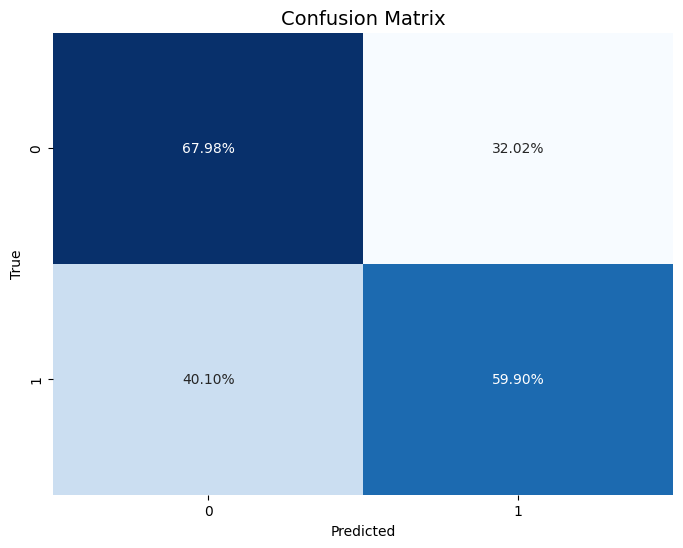

In [25]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm=cm, labels=classes, title='Confusion Matrix')

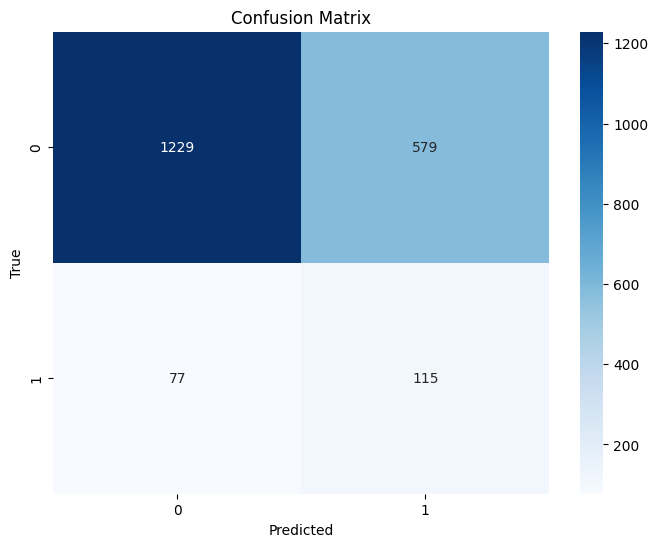

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_gen is your test data generator and model is your trained model
# predictions = model.predict(test_gen)
# predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_gen.labels

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("F1 Score: {}".format(f1_score(y_true,y_pred)))
print("Recall score: {}".format(recall_score(y_true,y_pred)))
print("Precision score: {}".format(precision_score(y_true,y_pred)))

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")

F1 Score: 0.25959367945823925
Recall score: 0.5989583333333334
Precision score: 0.16570605187319884
Sensitivity (True Positive Rate): 0.5990
Specificity (True Negative Rate): 0.6798


### PR Curve

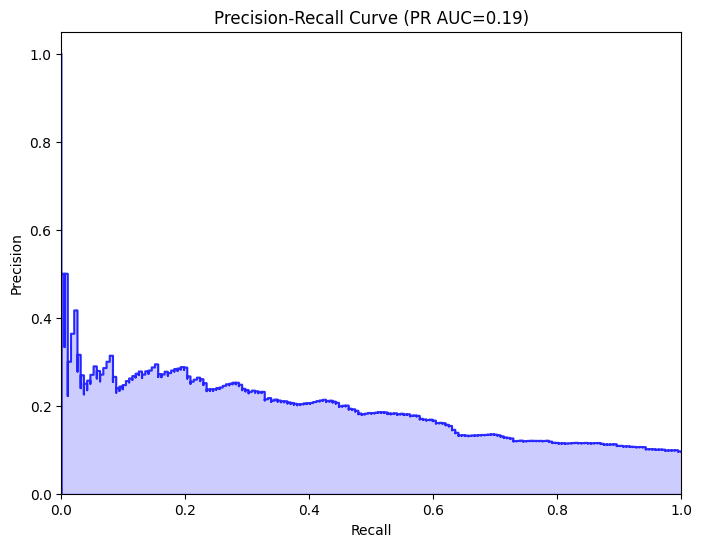

In [28]:
from sklearn.metrics import auc, precision_recall_curve, f1_score, average_precision_score

# Make predictions on the test data
y_scores = preds

y_scores = y_scores[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)  # Assuming binary classification, use y_scores[:, 1]

# Calculate AUC for precision-recall curve
pr_auc = auc(recall, precision)

# Alternatively, you can use tf.keras.metrics.AUC directly
pr_auc_metric = tf.keras.metrics.AUC(curve='PR')
pr_auc_metric.update_state(y_true, y_scores)  # Assuming binary classification, use y_scores[:, 1]
pr_auc = pr_auc_metric.result().numpy()

# Visualize the PR curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (PR AUC={pr_auc:0.2f})')
plt.show()

## Best model evaluate

In [29]:
# The same as the above
best_model = Sequential([
                        base_model,
                        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
                        Dense(512, kernel_regularizer=regularizers.l2(0.02),
                                   activity_regularizer=regularizers.l1(0.008),
                                   bias_regularizer=regularizers.l1(0.008), activation='relu'),
                        Dropout(rate=0.55),
                    #     Dense(251, kernel_regularizer=regularizers.l2(0.016),
                    #                activity_regularizer=regularizers.l1(0.006),
                    #                bias_regularizer=regularizers.l1(0.006), activation='relu'),
                        Dense(class_count, activation= 'softmax')])


best_model.load_weights(checkpoint_filepath)

best_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate= 0.001),
                  loss='categorical_crossentropy',
                  metrics= [tf.keras.metrics.Recall(name='recall'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.AUC(curve='ROC', name='auc'),
                            tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
                            'accuracy'])

In [30]:
best_preds = best_model.predict(test_gen)
best_y_pred = np.argmax(best_preds, axis=1)
print(best_y_pred)

25/25 [==============================] - 50s 2s/step
[1 0 0 ... 1 0 1]


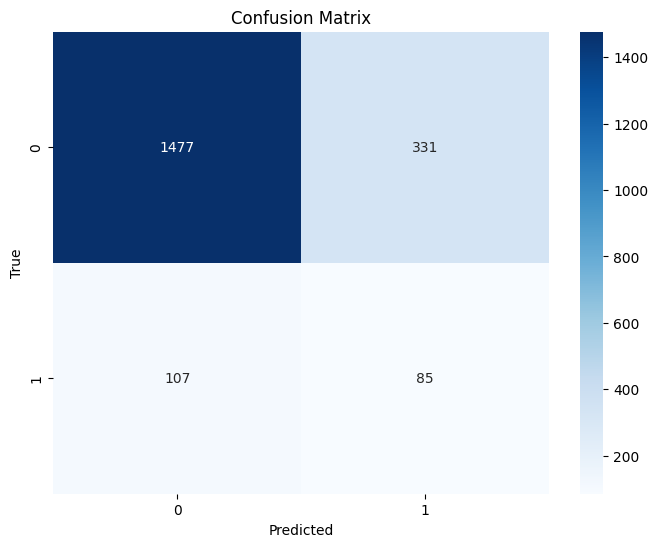

In [31]:
# Create confusion matrix
best_conf_matrix = confusion_matrix(true_labels, best_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
print("F1 Score: {}".format(f1_score(y_true,best_y_pred)))
print("Recall score: {}".format(recall_score(y_true,best_y_pred)))
print("Precision score: {}".format(precision_score(y_true,best_y_pred)))

# Extract values from confusion matrix
tn, fp, fn, tp = best_conf_matrix.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")

F1 Score: 0.27960526315789475
Recall score: 0.4427083333333333
Precision score: 0.20432692307692307
Sensitivity (True Positive Rate): 0.4427
Specificity (True Negative Rate): 0.8169


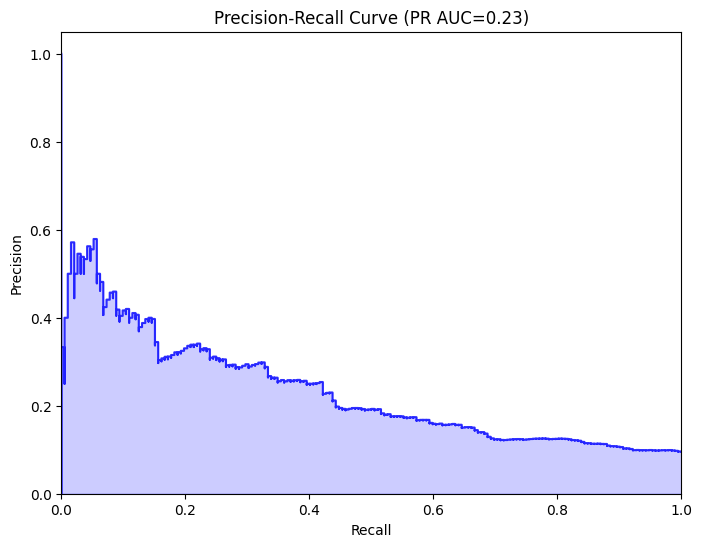

In [33]:
from sklearn.metrics import auc, precision_recall_curve, f1_score, average_precision_score

# Make predictions on the test data
best_y_scores = best_preds
best_y_scores = best_y_scores[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, best_y_scores)  # Assuming binary classification, use y_scores[:, 1]

# Calculate AUC for precision-recall curve
pr_auc = auc(recall, precision)

# Alternatively, you can use tf.keras.metrics.AUC directly
pr_auc_metric = tf.keras.metrics.AUC(curve='PR')
pr_auc_metric.update_state(y_true, best_y_scores)  # Assuming binary classification, use y_scores[:, 1]
pr_auc = pr_auc_metric.result().numpy()

# Visualize the PR curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (PR AUC={pr_auc:0.2f})')
plt.show()